### Import

In [1]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_distances
import random
from sklearn.model_selection import train_test_split
import umap
import pandas as pd
from torch import nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm.data import create_transform
from timm.data.mixup import Mixup

c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\danyo\miniconda3\envs\hecto\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Config

In [2]:
CFG = {
    'IMG_SIZE': 384,
    'BATCH_SIZE': 32,
    'EPOCHS': 20,
    'LEARNING_RATE': 1e-4,
    'SEED' : 42
}

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 경로 (환경에 따라 다를 수 있음)
font_path = "C:/Windows/Fonts/malgun.ttf"  
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

### Seed 고정 함수

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

### Custom Dataset

In [6]:
import os
import numpy as np
import cv2
from torch.utils.data import Dataset
from PIL import Image 

def imread_unicode(path):
    stream = np.fromfile(path, dtype=np.uint8)
    image = cv2.imdecode(stream, cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []

        if is_test:
            # 테스트셋: 라벨 없이 이미지 경로만 저장
            for fname in sorted(os.listdir(root_dir)):
                if fname.lower().endswith(('.jpg')):
                    img_path = os.path.join(root_dir, fname)
                    self.samples.append((img_path,))
        else:
            # 학습셋: 클래스별 폴더 구조에서 라벨 추출
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

            for cls_name in self.classes:
                cls_folder = os.path.join(root_dir, cls_name)
                for fname in os.listdir(cls_folder):
                    if fname.lower().endswith(('.jpg')):
                        img_path = os.path.join(cls_folder, fname)
                        label = self.class_to_idx[cls_name]
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    # # albumentation 용
    # def __getitem__(self, idx):
    #     if self.is_test:
    #         img_path = self.samples[idx][0]
    #         # image = Image.open(img_path).convert('RGB')
    #         image = imread_unicode(img_path)  # 수정됨
    #         if self.transform:
    #             # image = self.transform(image)
    #             image = self.transform(image=image)['image']
    #         return image
    #     else:
    #         img_path, label = self.samples[idx]
    #         # image = Image.open(img_path).convert('RGB')
    #         image = imread_unicode(img_path)  # 수정됨
    #         if self.transform:
    #             # image = self.transform(image)
    #             image = self.transform(image=image)['image']
    #         return image, label

    # timm 용
    def __getitem__(self, idx):
        if self.is_test:
            img_path = self.samples[idx][0]
            image = imread_unicode(img_path)  # numpy.ndarray
            image = Image.fromarray(image)    # numpy → PIL
            if self.transform:
                image = self.transform(image)  # timm transform은 PIL 이미지 사용
            return image
        else:
            img_path, label = self.samples[idx]
            image = imread_unicode(img_path)  # numpy.ndarray
            image = Image.fromarray(image)    # numpy → PIL
            if self.transform:
                image = self.transform(image)
            return image, label
        
    # # image, label, img_path도 반환해야할때
    # def __getitem__(self, idx):
    #     if self.is_test:
    #         img_path = self.samples[idx][0]
    #         image = imread_unicode(img_path)
    #         if self.transform:
    #             image = self.transform(image=image)['image']
    #         return image
    #     else:
    #         img_path, label = self.samples[idx]
    #         image = imread_unicode(img_path)
    #         if self.transform:
    #             image = self.transform(image=image)['image']
    #         return image, label, img_path  # ✅ 경로도 함께 반환!

### Transform 설정

In [7]:
train_transform = create_transform(
    input_size=CFG['IMG_SIZE'],
    is_training=True,
    auto_augment='rand-m9-mstd0.5-inc1',
    interpolation='bicubic',  # Transformer 계열은 bicubic이 안정적
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

val_transform = create_transform(
    input_size=CFG['IMG_SIZE'],
    is_training=False,
    interpolation='bicubic',
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225)
)

### Dataset 구성

In [8]:
train_root = './data/train'
test_root = './data/test'

class_names = [d for d in os.listdir(train_root) if os.path.isdir(os.path.join(train_root, d))]

### Load Full Dataset

In [9]:
# 전체 데이터셋 로드
full_dataset = CustomImageDataset(train_root, transform=None)
print(f"총 이미지 수: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_names = full_dataset.classes

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform 각각 적용
train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)

print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

# 모델 정의
class BaseModel(nn.Module):
    def __init__(self, num_classes):
        super(BaseModel, self).__init__()
        self.backbone = models.densenet169(pretrained=True)  # ResNet18 모델 불러오기
        # resnet
        # self.feature_dim = self.backbone.fc.in_features 
        # self.backbone.fc = nn.Identity()  # feature extractor로만 사용
        
        # convnext
        # self.feature_dim = self.backbone.classifier[2].in_features  
        # self.backbone.classifier = nn.Identity()  # classifier 대신 feature extractor로만 쓰기 위해 제거
        
        # swinTransformer tiny
        # self.feature_dim = self.backbone.head.in_features  # swin은 head가 마지막 fc
        # self.backbone.head = nn.Identity()  # feature extractor로만 사용
        
        # efficientNet
        # self.feature_dim = self.backbone.classifier[1].in_features  # EfficientNet 구조 기준
        # self.backbone.classifier = nn.Identity()  # feature extractor로 사용

        # densenet        
        self.feature_dim = self.backbone.classifier.in_features  

        self.head = nn.Linear(self.feature_dim, num_classes)  # 분류기

    # def forward(self, x): # -> resnet, swin, efficient
    #     x = self.backbone(x)       
    #     x = self.head(x) 
    #     return x

    # def forward(self, x): # -> convnext
    #     x = self.backbone(x)       # [B, C, 1, 1]
    #     x = x.view(x.size(0), -1)  # or x = torch.flatten(x, 1)
    #     x = self.head(x)           # [B, num_classes]
    #     return x

    def forward(self, x): # -> densenet
        features = self.backbone.features(x)           # [B, C, H, W]
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))       # [B, C, 1, 1]
        out = torch.flatten(out, 1)                    # [B, C]
        out = self.head(out)                           # [B, num_classes]
        return out

총 이미지 수: 33132
train 이미지 수: 26505, valid 이미지 수: 6627


In [14]:
import timm
class CosineSimilarityClassifier(nn.Module):
    def __init__(self, in_features, num_classes, scale=30.0):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(num_classes, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.scale = scale

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)               # feature 정규화
        w = F.normalize(self.weight, p=2, dim=1)     # weight 정규화
        logits = self.scale * torch.matmul(x, w.T)   # cosine similarity × scaling
        return logits

class TimmModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True, scale=30.0):
        super(TimmModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)  
        # base
        self.feature_dim = self.backbone.num_features
        # self.head = nn.Linear(self.feature_dim, num_classes)
        self.head = CosineSimilarityClassifier(self.feature_dim, num_classes, scale=scale) # coine similarity classifier

    def forward(self, x):
        x = self.backbone(x)
        # print(x.shape)
        x = self.head(x)
        return x

### Load Model

In [16]:
model = TimmModel(model_name='tiny_vit_21m_384', num_classes=len(class_names))
model.load_state_dict(torch.load('./checkpoints/tiny_vit_21m_384_randaug_cosine/62_0.2205_0.0780_0.0783.pth', map_location=device))
model.to(device)

TimmModel(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): ConvNorm(
              (conv): Conv2d(384, 384, ker

### 확률 분포 확인

In [17]:
# 확률 분포 저장용
all_probs = []
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        probs = F.softmax(logits, dim=1)  # 확률로 변환

        all_probs.append(probs.cpu())
        all_preds.append(probs.argmax(dim=1).cpu())
        all_labels.append(labels.cpu())

# 텐서 이어붙이기
all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# 확신하게 틀린 샘플 골라보기
confident_wrong = []
low_conf_wrong = []

low_conf_threshold = 0.5  # 낮은 confidence 임계값
high_conf_threshold = 0.9 # 높은 confidence 임계값

for i in range(len(all_labels)):
    pred = all_preds[i].item()
    true = all_labels[i].item()
    confidence = all_probs[i][pred].item()

    if pred != true:
        if confidence > high_conf_threshold:
            confident_wrong.append((i, confidence, pred, true))
        elif confidence < low_conf_threshold:
            low_conf_wrong.append((i, confidence, pred, true))

print(f'Confident wrong samples count: {len(confident_wrong)}')
print(f'Low confidence wrong samples count: {len(low_conf_wrong)}')


Confident wrong samples count: 33
Low confidence wrong samples count: 24


In [18]:
# 예: class_names = ['carA', 'carB', 'carC', ...] 인덱스 순서대로 클래스명 리스트

with open('confident_wrong_samples_vit_384.txt', 'w') as f:
    f.write('Index\tConfidence\tPredicted\tPredicted_name\tTrue\tTrue_name\n')
    for idx, conf, pred, true in confident_wrong:
        f.write(f'{idx}\t{conf:.4f}\t{pred}\t{class_names[pred]}\t{true}\t{class_names[true]}\n')

with open('low_conf_wrong_samples_vit_384.txt', 'w') as f:
    f.write('Index\tConfidence\tPredicted\tPredicted_name\tTrue\tTrue_name\n')
    for idx, conf, pred, true in low_conf_wrong:
        f.write(f'{idx}\t{conf:.4f}\t{pred}\t{class_names[pred]}\t{true}\t{class_names[true]}\n')

print('Confident wrong samples saved to confident_wrong_samples.txt with class names')
print('Low confidence wrong samples saved to low_conf_wrong_samples.txt with class names')


Confident wrong samples saved to confident_wrong_samples.txt with class names
Low confidence wrong samples saved to low_conf_wrong_samples.txt with class names


In [ ]:
# --- 확신 크게 틀린 샘플 시각화 (최대 3개) ---
print("\nHigh confidence but wrong samples:")
for idx, (i, conf, pred, true) in enumerate(confident_wrong):
    img = val_dataset[i][0].permute(1, 2, 0).numpy()
    plt.figure()
    plt.imshow(img)
    plt.title(f'Conf: {conf:.2f} | Pred: {class_names[pred]} | True: {class_names[true]}')
    plt.axis('off')
    plt.show()

In [ ]:
# --- 자신 없는데 틀린 샘플 시각화 (최대 3개) ---
print("\nLow confidence and wrong samples:")
for idx, (i, conf, pred, true) in enumerate(low_conf_wrong[:3]):
    img = val_dataset[i][0].permute(1, 2, 0).numpy()

    plt.figure()
    plt.imshow(img)
    plt.title(f'Conf: {conf:.2f} | Pred: {class_names[pred]} | True: {class_names[true]}')
    plt.axis('off')
    plt.show()

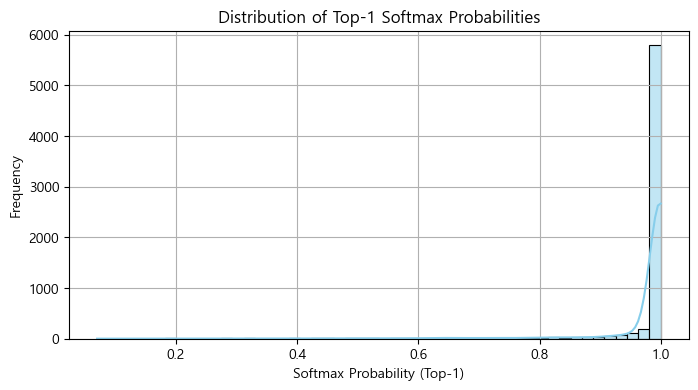

In [14]:
# --- Top-1 확률 분포 시각화 ---
top1_probs = all_probs.max(dim=1)[0]

plt.figure(figsize=(8, 4))
sns.histplot(top1_probs.numpy(), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Top-1 Softmax Probabilities')
plt.xlabel('Softmax Probability (Top-1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

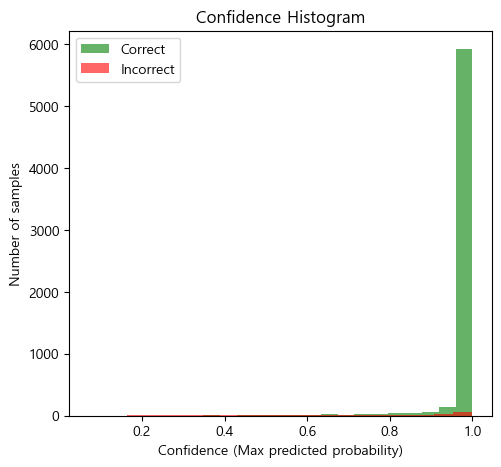

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve

# all_probs, all_preds, all_labels 는 이미 존재하는 상태 기준

# 1. Confidence histogram 그리기
# 예측 확률(신뢰도): 각 샘플에서 모델이 예측한 클래스의 확률
confidences = all_probs.max(dim=1)[0].numpy()
correct = (all_preds == all_labels).numpy()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(confidences[correct], bins=20, alpha=0.6, label='Correct', color='green')
plt.hist(confidences[~correct], bins=20, alpha=0.6, label='Incorrect', color='red')
plt.title('Confidence Histogram')
plt.xlabel('Confidence (Max predicted probability)')
plt.ylabel('Number of samples')
plt.legend()

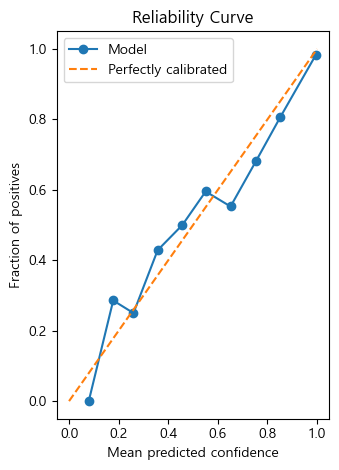

In [16]:
# 2. Reliability curve (Calibration curve)
# sklearn calibration_curve 사용
prob_true, prob_pred = calibration_curve(correct, confidences, n_bins=10, strategy='uniform')

plt.subplot(1,2,2)
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1], [0,1], linestyle='--', label='Perfectly calibrated')
plt.title('Reliability Curve')
plt.xlabel('Mean predicted confidence')
plt.ylabel('Fraction of positives')
plt.legend()

plt.tight_layout()
plt.show()

### 상위 오분류 조합 추출 후 저장

In [17]:
from collections import defaultdict

# 혼동 쌍 개수 세기
confusion_counts = defaultdict(int)
for _,_,true_cls, pred_cls in confident_wrong:
    confusion_counts[(true_cls, pred_cls)] += 1

# 혼동 강도 높은 (정답, 예측) 쌍 상위 N개 추출
N = 20
top_misclassified = sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)[:N]

# 파일로 저장
# with open('confusion_pairs_20.txt', 'w', encoding='utf-8') as f:
for i, ((true_idx, pred_idx), count) in enumerate(top_misclassified):
    true_name = class_names[true_idx]
    pred_name = class_names[pred_idx]
    print(f"[Top {i+1}] 실제: {true_name} → 예측: {pred_name} ({count}건)")
        # f.write(f"{true_name} {pred_name}\n")

[Top 1] 실제: 아반떼_하이브리드_CN7_2021_2023 → 예측: 아반떼_CN7_2021_2023 (4건)
[Top 2] 실제: K5_3세대_2020_2023 → 예측: K5_하이브리드_3세대_2020_2023 (4건)
[Top 3] 실제: GLC_클래스_X253_2023 → 예측: GLC_클래스_X253_2020_2022 (4건)
[Top 4] 실제: 콰트로포르테_2014_2016 → 예측: 콰트로포르테_2017_2022 (4건)
[Top 5] 실제: GLC_클래스_X253_2020_2022 → 예측: GLC_클래스_X253_2023 (3건)
[Top 6] 실제: 7시리즈_G11_2016_2018 → 예측: 7시리즈_G11_2019_2022 (3건)
[Top 7] 실제: 레인지로버_4세대_2018_2022 → 예측: 레인지로버_4세대_2014_2017 (3건)
[Top 8] 실제: K8_하이브리드_2022_2024 → 예측: K8_2022_2024 (3건)
[Top 9] 실제: 트레일블레이저_2023 → 예측: 트레일블레이저_2021_2022 (3건)
[Top 10] 실제: 4시리즈_G22_2021_2023 → 예측: 4시리즈_G22_2024_2025 (3건)
[Top 11] 실제: 레인지로버_이보크_2세대_2020_2022 → 예측: 레인지로버_이보크_2세대_2023_2024 (3건)
[Top 12] 실제: 뉴_A6_2012_2014 → 예측: 뉴_A6_2015_2018 (3건)
[Top 13] 실제: 더_뉴_그랜드_스타렉스_2018_2021 → 예측: 그랜드_스타렉스_2016_2018 (2건)
[Top 14] 실제: 스팅어_마이스터_2021_2023 → 예측: 스팅어_2018_2020 (2건)
[Top 15] 실제: 랭글러_JL_2018_2024 → 예측: 글래디에이터_JT_2020_2023 (2건)
[Top 16] 실제: 더_뉴_스파크_2019_2022 → 예측: 더_넥스트_스파크_2016_2018 (2건)
[Top 17] 실제: 그랜드_스타렉

### 오분류 비율 높은 클래스 추출

In [18]:
from collections import defaultdict, Counter

# 전체 정답 클래스별 등장 횟수 카운트
class_total_counts = defaultdict(int)
class_wrong_counts = defaultdict(int)  # ❗️추가 필요
mistake_detail = defaultdict(Counter)  # 착각한 클래스 기록

# 전체 정답 수 세기
for label in all_labels:
    class_total_counts[label.item()] += 1

# confident wrong 분석
for i, confidence, pred, true in confident_wrong:
    class_wrong_counts[true] += 1  # ❗️이게 핵심이야
    mistake_detail[true][pred] += 1

# 오분류율 계산
mistake_ratios = []
for cls in range(len(class_names)):
    total = class_total_counts[cls]
    wrong = class_wrong_counts[cls]
    if total > 0:
        ratio = wrong / total
        mistake_ratios.append((cls, ratio, total))

# 오분류율 높은 순 정렬
mistake_ratios.sort(key=lambda x: x[1], reverse=True)

# 출력
print("\n[오분류율 Top 10 클래스 (confident wrong 기준)]")
for i, (cls, ratio, total) in enumerate(mistake_ratios[:10]):
    wrong = int(ratio * total)
    print(f"[클래스 {i+1}] {class_names[cls]}: 오분류율 {ratio:.2%} (총 {total}개 중 {wrong}개 confident wrong)")

    counter = mistake_detail[cls]
    top_confusions = counter.most_common(3)
    for pred_cls, cnt in top_confusions:
        pred_name = class_names[pred_cls]
        print(f"    - 착각한 클래스: {pred_name} ({cnt}건)")



[오분류율 Top 10 클래스 (confident wrong 기준)]
[클래스 1] 4시리즈_G22_2024_2025: 오분류율 26.67% (총 15개 중 4개 confident wrong)
    - 착각한 클래스: 4시리즈_G22_2021_2023 (3건)
    - 착각한 클래스: i4_2022_2024 (1건)
[클래스 2] 콰트로포르테_2017_2022: 오분류율 26.67% (총 15개 중 4개 confident wrong)
    - 착각한 클래스: 콰트로포르테_2014_2016 (4건)
[클래스 3] GLC_클래스_X253_2020_2022: 오분류율 23.53% (총 17개 중 4개 confident wrong)
    - 착각한 클래스: GLC_클래스_X253_2023 (4건)
[클래스 4] K5_하이브리드_3세대_2020_2023: 오분류율 23.53% (총 17개 중 4개 confident wrong)
    - 착각한 클래스: K5_3세대_2020_2023 (4건)
[클래스 5] 아반떼_CN7_2021_2023: 오분류율 23.53% (총 17개 중 4개 confident wrong)
    - 착각한 클래스: 아반떼_하이브리드_CN7_2021_2023 (4건)
[클래스 6] K8_2022_2024: 오분류율 18.75% (총 16개 중 3개 confident wrong)
    - 착각한 클래스: K8_하이브리드_2022_2024 (3건)
[클래스 7] 트레일블레이저_2021_2022: 오분류율 18.75% (총 16개 중 3개 confident wrong)
    - 착각한 클래스: 트레일블레이저_2023 (3건)
[클래스 8] GLC_클래스_X253_2023: 오분류율 17.65% (총 17개 중 3개 confident wrong)
    - 착각한 클래스: GLC_클래스_X253_2020_2022 (3건)
[클래스 9] 뉴_A6_2015_2018: 오분류율 17.65% (총 17개 중 3개 confident wrong)
   

### Class-wise LogLoss 분석

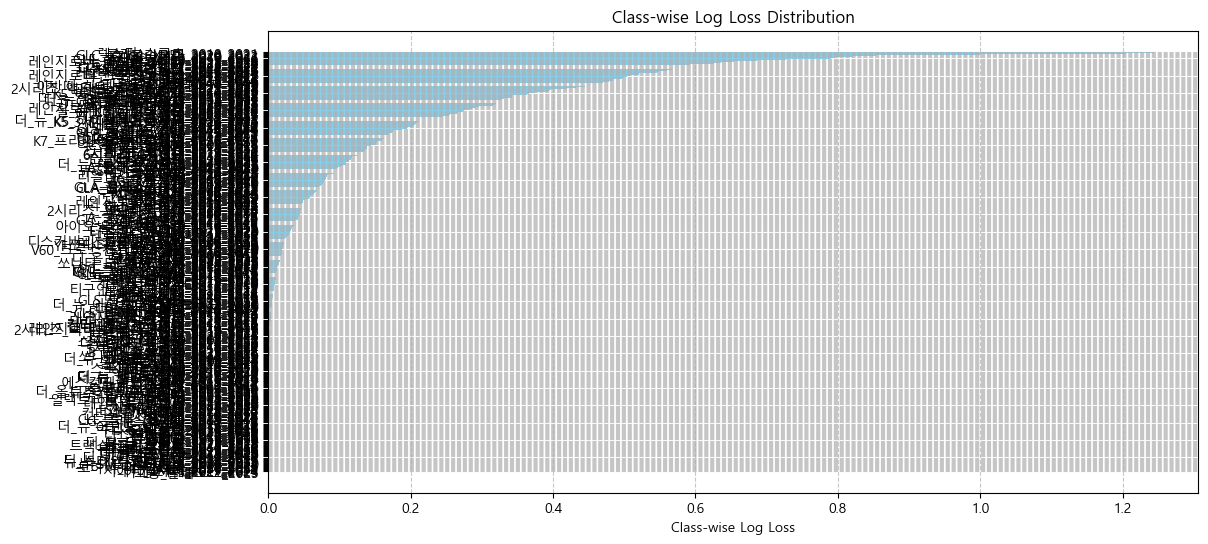

                       class   logloss
278        렉스턴_스포츠_2018_2021  1.244237
80    GLC_클래스_X253_2020_2022  1.204734
97         K7_프리미어_2020_2021  0.999121
7         3008_2세대_2018_2023  0.853921
387           파나메라_2010_2016  0.821656
84    GLE_클래스_W167_2019_2024  0.795958
9         3시리즈_F30_2013_2018  0.789809
277  레인지로버_이보크_2세대_2023_2024  0.727342
355        카니발_4세대_2022_2023  0.686058
111          Q5_FY_2021_2024  0.653575


In [54]:
# 2) 클래스별 logloss 함수 (여기에 그대로 붙여쓰기)
def classwise_logloss(y_true, y_pred_proba, class_names=None):
    num_classes = y_pred_proba.shape[1]
    logloss_per_class = []

    for c in range(num_classes):
        idx = (y_true == c)
        if np.sum(idx) == 0:
            logloss_per_class.append(np.nan)
            continue

        y_true_binary = (y_true[idx] == c).astype(int)
        y_pred_c = y_pred_proba[idx, c]
        loss_c = log_loss(y_true_binary, y_pred_c, labels=[0,1])
        logloss_per_class.append(loss_c)

    logloss_per_class = np.array(logloss_per_class)

    plt.figure(figsize=(12,6))
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]
    sorted_idx = np.argsort(logloss_per_class)
    plt.barh(np.array(class_names)[sorted_idx], logloss_per_class[sorted_idx], color='skyblue')
    plt.xlabel('Class-wise Log Loss')
    plt.title('Class-wise Log Loss Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return pd.DataFrame({'class': class_names, 'logloss': logloss_per_class})

# 3) torch tensor → numpy 변환
y_true_np = all_labels.numpy()
y_pred_proba_np = all_probs.numpy()

# # (옵션) 클래스 이름 리스트 있으면 넣어주기, 없으면 None
# class_names = None  # 또는 ['class0', 'class1', ..., 'class395']

# 4) 호출해서 결과 출력 + 시각화
df_class_loss = classwise_logloss(y_true_np, y_pred_proba_np, class_names=class_names)
print(df_class_loss.sort_values('logloss', ascending=False).head(10))  # logloss 높은 10개만 출력